In [1]:
# Scientific computing and data manipulation
import math
import time
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp

# Visualization
import matplotlib.pyplot as plt

# Machine learning and deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, LeaveOneOut

# Hyperparameter optimization
import optuna

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EarlyStopping function

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

In [4]:
#import random

# To fix the random seed
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)
#random.seed(seed)

# Ensure deterministic behavior in PyTorch
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# DEFINE PARAMETERS

In [5]:
# Define constant parameters

R = (6.4*10e-3)/2 # Tubular radius, units: m
qp_480 = 1.3 * 10e-4 * 60 # Photon flux, units: moles photons · m-2 · min-1
Vr = 4.78 * 10e-6# Reactor volume, units: m3
CB = 0.4 # Concentartion of reactant B, units: M

# Calculate photon flux at different power ratings

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

In [6]:
# Experimentally measured parameters

phi_n1 = 0.07508614 # Quantum yield, units: mole/Einstien
k11 = 0.01953897 # rate constant for formation of species C
k21 = 0.11706072 # rate constant for formation of species E

# Regressed parameters

mpc1 = 94.6*0.02*(1/1000) # photon absorption by photocatalyst
ka1 =  324.7*(1/1000) # Napierian molar absorption coefficient of specis A, units: m2/mol
kc1 = 345.5*(1/1000) # Napierian molar absorption coefficient of specis C, units: m2/mol 

# LOAD DATA

In [7]:
# Extract Data from the Excel Data Sheet

Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0


Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [8]:
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (9, 36, 5)


In [9]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (9, 36, 3)


In [10]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 3))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

RNN_input = scaler_X.transform(RNN_input.reshape(-1, 5)).reshape(-1,36,5)
RNN_output = scaler_y.transform(RNN_output.reshape(-1, 3)).reshape(-1,36,3)

mean_y = torch.from_numpy(scaler_y.mean_).float()
std_y = torch.from_numpy(np.sqrt(scaler_y.var_)).float()

[  0.3 280.    1.    0.    0. ]
[6.66666667e-03 2.24000000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.29611469 0.69253774 0.01134757]
[2.33151041e-02 2.22718238e-02 1.73960109e-05]


In [11]:
torch.save(mean_y,'mean_y.pt')
torch.save(std_y,'std_y.pt')
np.save('mean_X.npy',scaler_X.mean_)
np.save('std_X.npy',np.sqrt(scaler_X.var_))

In [12]:
# split into train and test sets
x_train = RNN_input[:7,:,:]
x_test  = RNN_input[7:,:,:]

y_train = RNN_output[:7,:,:]
y_test =  RNN_output[7:,:,:]

In [13]:
############################# Split Train, Test, and Validation dataset ##################################

#X_train, x_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=42)

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"x_train shape is {x_train.shape}, x_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape}, y_test shape is {y_test.shape}")

x_train shape is (7, 36, 5), x_test shape is (2, 36, 5)
y_train shape is (7, 36, 3), y_test shape is (2, 36, 3)


In [14]:
mean_X = np.load('mean_X.npy')
std_X = np.load('std_X.npy')
mean_y = torch.load('mean_y.pt')
std_y=torch.load('std_y.pt')

# GENERATING COLLOCATION POINTS

In [15]:
# generating collocation points 
# u1 = Reactant feed concentration, u2 = Power rating

u1_physics_list = np.linspace(0.1, 1, 20)
u2_physics_list = np.linspace(100, 1000, 20) 

In [16]:
u1_physics_input = list()
u2_physics_input = list()
Y_1_list = []
Y_2_list = []
Y_3_list = []

for num_id, u1 in enumerate(u1_physics_list):
    print(f"{num_id + 1} out of {u1_physics_list.shape[0]}")    #just to count and keep track
    CBi = u1 
    
    for u2 in u2_physics_list:
        F = u2 
        
        u1_physics_input.append(u1)
        u2_physics_input.append(u2)
        
        Y_1 = 1
        Y_2 = 0
        Y_3 = 0
    
        Y_1_list.append(Y_1)
        Y_2_list.append(Y_2)
        Y_3_list.append(Y_3)

1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


In [17]:
# collate input 

u1_physics_input = np.array(u1_physics_input)
u1_physics_input = u1_physics_input.reshape(-1,1,1)

u2_physics_input = np.array(u2_physics_input)
u2_physics_input = u2_physics_input.reshape(-1,1,1)

Y_1_list = np.array(Y_1_list)
Y_1_list = Y_1_list.reshape(-1,1,1)

Y_2_list = np.array(Y_2_list)
Y_2_list = Y_2_list.reshape(-1,1,1)

Y_3_list = np.array(Y_3_list)
Y_3_list = Y_3_list.reshape(-1,1,1)

RNN_physics_input_tempc = np.concatenate((u1_physics_input, u2_physics_input, Y_1_list, Y_2_list, Y_3_list), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step
"""

RNN_physics_input_tempc = RNN_physics_input_tempc.repeat(36, axis=1)
print("RNN_physics_input_temp shape is {}".format(RNN_physics_input_tempc.shape))

RNN_physics_input_temp shape is (400, 36, 5)


In [18]:
RNN_physics_input_tempc = scaler_X.transform(RNN_physics_input_tempc.reshape(-1, 5)).reshape(-1,36,5)

In [19]:
# X_collocation_train
x_collocation_train = RNN_physics_input_tempc[:,:,:]

In [20]:
print(f'X_collocation_train shape is: {x_collocation_train.shape}')

X_collocation_train shape is: (400, 36, 5)


# TRANSFORMING DATA FOR TRAINING

In [21]:
x_collocation_train = torch.from_numpy(x_collocation_train).float()

In [22]:
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

In [23]:
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [24]:
dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# DEFINING RNN

In [25]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False                                             
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

In [26]:
# Adaptive Time Step

time = X1
print(time)
# Compute t_step as before
t_step = np.diff(time)
print(t_step)
t_step = torch.from_numpy(t_step)

[ 0.          1.          2.          3.          4.          5.
  5.03586213  5.14649097  5.30111004  5.4649041   5.63867566  5.82331844
  6.01982984  6.22932528  6.4530548   6.69242217  6.94900701  7.22459021
  7.5211832   7.84106147  8.18680287  8.56133087  8.96796312  9.41046508
  9.89310801 10.42072996 10.99879691 11.63345974 13.1008564  13.94961458
 14.88695124 15.92250695 17.06627394 18.32828423 19.71819689 21.24480099]
[1.         1.         1.         1.         1.         0.03586213
 0.11062884 0.15461907 0.16379406 0.17377156 0.18464278 0.1965114
 0.20949544 0.22372951 0.23936737 0.25658484 0.2755832  0.29659298
 0.31987827 0.3457414  0.374528   0.40663225 0.44250195 0.48264293
 0.52762195 0.57806695 0.63466283 1.46739666 0.84875818 0.93733666
 1.03555572 1.14376698 1.26201029 1.38991266 1.5266041 ]


# RNN and PHYSICS INFORMED RNN

In [27]:
def train_model(model, patience, n_epochs, X_collocation_train):
    
    train_losses, valid_losses = [], []
    avg_train_losses, avg_valid_losses = [], []
    y_scaled_error = []

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch[0].to(device), y_batch[0].to(device)
            optimizer.zero_grad()

            NN_outputd = model(x_batch)

            # Data-driven loss
            loss1 = torch.mean((NN_outputd - y_batch) ** 2)

            # Physics-based loss using collocation points
            X_col = X_collocation_train.to(device)
            NN_output = model(X_col)
            CA_in = X_col[:, :, 2] * std_X[2] + mean_X[2]
            CC_in = X_col[:, :, 3] * std_X[3] + mean_X[3]
            CE_in = X_col[:, :, 4] * std_X[4] + mean_X[4]
            CB = 0.4 * 1000  # mol/m3
            CAo = X_col[:, :, 0] * std_X[0] + mean_X[0]
            CAo = CAo * 1000
            qp = 1.3 * 10e-4 * 60 * (X_col[:, :, 1] * std_X[1] + mean_X[1]) / 480
            qp = qp.to(device)

            NN_output = NN_output * std_y.to(device) + mean_y.to(device)

            dCA = torch.cat([
                (NN_output[:, 1:2, 0] - CA_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step[-1])
            ], dim=1)

            dCC = torch.cat([
                (NN_output[:, 1:2, 1] - CC_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step[-1])
            ], dim=1)

            dCE = torch.cat([
                (NN_output[:, 1:2, 2] - CE_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 2] - NN_output[:, :-2, 2]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 2] - NN_output[:, -2:-1, 2]) / (t_step[-1])
            ], dim=1)

            lossCA = dCA - ((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo))
                            *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[ :,:, 1]*CAo)*2*R)))
            lossCA = torch.mean(lossCA**2)
            
            lossCC = dCC - ((k11*CB)/(k11*CB+k21)**1)*((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[:,:, 0]*CAo+kc1*NN_output[ :,:, 1]*CAo))
                                                       *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo)*2*R)))**1
            lossCC = torch.mean(lossCC**2)
            
            lossCE = dCE - (k21/(k11*CB+k21)**1)*((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[ :,:, 0]*CAo+kc1*NN_output[:,:, 1]*CAo))
                                                  *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo)*2*R)))**1 
            lossCE = torch.mean(lossCE**2)

            loss = loss1 + lossCA + lossCC + lossCE # manual scaling of physics losses if needed
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        for x_valbatch, y_valbatch in val_loader:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            NN_outputv = model(x_valbatch)
            loss = torch.mean((NN_outputv - y_valbatch) ** 2)

            valid_losses.append(loss.item())

        # Logging
        train_loss = np.mean(train_losses)
        valid_loss = np.mean(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[{epoch}/{n_epochs}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f}")

        train_losses, valid_losses = [], []
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Evaluate best model on validation set once
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()

    final_predictions = []
    final_targets = []

    with torch.no_grad():
        for x_valbatch, y_valbatch in dataloader_physics_test:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            output = model(x_valbatch)

            preds = scaler_y.inverse_transform(output.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)
            targets = scaler_y.inverse_transform(y_valbatch.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)

            # Compute scaled loss
            c1 = np.sum(np.abs(preds[-1, :, 0] - targets[-1, :, 0]))
            c2 = np.sum(np.abs(preds[-1, :, 1] - targets[-1, :, 1]))
            c3 = np.sum(np.abs(preds[-1, :, 2] - targets[-1, :, 2]))
            scaled_loss = (3.377069851 * c1 + 1.443964636 * c2 + 88.12458286 * c3) / 100

            y_scaled_error.append(scaled_loss)

            final_predictions.append(preds)
            final_targets.append(targets)

    final_predictions = np.concatenate(final_predictions, axis=0)
    final_targets = np.concatenate(final_targets, axis=0)

    return model, avg_train_losses, avg_valid_losses, np.mean(avg_valid_losses), y_scaled_error, final_predictions, final_targets


In [28]:
# create loocv procedure
from sklearn.model_selection import KFold
cv = LeaveOneOut()
batch_size = 32
k = 7

In [29]:
y_glob = []  # Will be a list of lists: shape (n_folds, n_repeats_per_fold)
sc_y_glob = []

all_val_preds = []  # list of length n_folds, each item is (5, n_samples, 36, 3)
val_targets = None

for fold, (train_idx_A, val_idx_A) in enumerate(cv.split(x_train)):
    
    print(f"  Fold {fold + 1}/{k}")

    # Create TensorDatasets and DataLoaders
    train_datasetA = TensorDataset(x_train[train_idx_A], y_train[train_idx_A])
    val_datasetA = TensorDataset(x_train[val_idx_A], y_train[val_idx_A])
    train_loader = DataLoader(train_datasetA, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_datasetA, batch_size=batch_size, shuffle=False)
    
    # Select collocation data for this fold
    X_collocation_train_fold = x_collocation_train

    fold_errors = []
    sc_fold_errors = []

    for i in range(5):  # Repeat training to observe variability
        model_PINN = RNN(5, 3, 64, 1).to(device)
        print(f"  Training {i+1}/5 for Fold {fold+1}")
        print(model_PINN)

        n_epochs = 100
        patience = 100

        model_PINN, train_loss, valid_loss, test_error, mean_scaled, predictions, targets = train_model(
            model_PINN, patience, n_epochs, 
            X_collocation_train_fold)

        fold_errors.append(test_error)
        sc_fold_errors.append(mean_scaled)
        
        if i == 0:
            val_preds_fold = [predictions]
        else:
            val_preds_fold.append(predictions)

    y_glob.append(fold_errors)  # Mean Squared Errors
    sc_y_glob.append(sc_fold_errors) # Scaled Average Errors
    
    val_preds_fold = np.stack(val_preds_fold, axis=0)  # shape: (5, n_samples, 36, 3)
    all_val_preds.append(val_preds_fold)

    if fold == 0:  # Only store ground truth once
        val_targets = targets


# Convert to NumPy array for easier processing
y_glob = np.array(y_glob)  # shape: (n_folds, 5)
sc_y_glob = np.array(sc_y_glob)  # shape: (n_folds, 5)


  Fold 1/7
  Training 1/5 for Fold 1
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)


C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.74820 valid_loss: 2.35704
Validation loss decreased (inf --> 2.357038).  Saving model ...
[2/100] train_loss: 0.87133 valid_loss: 2.33179
Validation loss decreased (2.357038 --> 2.331793).  Saving model ...
[3/100] train_loss: 0.98664 valid_loss: 2.31995
Validation loss decreased (2.331793 --> 2.319945).  Saving model ...
[4/100] train_loss: 0.84847 valid_loss: 2.30629
Validation loss decreased (2.319945 --> 2.306294).  Saving model ...
[5/100] train_loss: 1.04582 valid_loss: 2.28519
Validation loss decreased (2.306294 --> 2.285188).  Saving model ...
[6/100] train_loss: 1.04110 valid_loss: 2.26115
Validation loss decreased (2.285188 --> 2.261151).  Saving model ...
[7/100] train_loss: 0.70499 valid_loss: 2.23694
Validation loss decreased (2.261151 --> 2.236940).  Saving model ...
[8/100] train_loss: 0.97745 valid_loss: 2.21743
Validation loss decreased (2.236940 --> 2.217431).  Saving model ...
[9/100] train_loss: 0.97515 valid_loss: 2.20146
Validation loss decre

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.80609 valid_loss: 2.31708
Validation loss decreased (2.327082 --> 2.317082).  Saving model ...
[3/100] train_loss: 0.91054 valid_loss: 2.30618
Validation loss decreased (2.317082 --> 2.306182).  Saving model ...
[4/100] train_loss: 0.97733 valid_loss: 2.30052
Validation loss decreased (2.306182 --> 2.300520).  Saving model ...
[5/100] train_loss: 1.05862 valid_loss: 2.28708
Validation loss decreased (2.300520 --> 2.287082).  Saving model ...
[6/100] train_loss: 0.88907 valid_loss: 2.27320
Validation loss decreased (2.287082 --> 2.273200).  Saving model ...
[7/100] train_loss: 0.79669 valid_loss: 2.26094
Validation loss decreased (2.273200 --> 2.260936).  Saving model ...
[8/100] train_loss: 0.77352 valid_loss: 2.24889
Validation loss decreased (2.260936 --> 2.248893).  Saving model ...
[9/100] train_loss: 0.73833 valid_loss: 2.23538
Validation loss decreased (2.248893 --> 2.235385).  Saving model ...
[10/100] train_loss: 0.79246 valid_loss: 2.22316
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.09497 valid_loss: 2.08064
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 0.98563 valid_loss: 2.07234
Validation loss decreased (2.078570 --> 2.072339).  Saving model ...
[4/100] train_loss: 0.98348 valid_loss: 2.06026
Validation loss decreased (2.072339 --> 2.060263).  Saving model ...
[5/100] train_loss: 0.84916 valid_loss: 2.04697
Validation loss decreased (2.060263 --> 2.046967).  Saving model ...
[6/100] train_loss: 0.77317 valid_loss: 2.03530
Validation loss decreased (2.046967 --> 2.035304).  Saving model ...
[7/100] train_loss: 0.83874 valid_loss: 2.02224
Validation loss decreased (2.035304 --> 2.022241).  Saving model ...
[8/100] train_loss: 0.83193 valid_loss: 2.00812
Validation loss decreased (2.022241 --> 2.008124).  Saving model ...
[9/100] train_loss: 0.76925 valid_loss: 1.99529
Validation loss decreased (2.008124 --> 1.995290).  Saving model ...
[10/100] train_loss: 0.81669 valid_loss: 1.98124
Validation loss decreased (1.995290 --> 1.981238

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.77952 valid_loss: 2.22355
Validation loss decreased (inf --> 2.223555).  Saving model ...
[2/100] train_loss: 0.99883 valid_loss: 2.20363
Validation loss decreased (2.223555 --> 2.203627).  Saving model ...
[3/100] train_loss: 0.80122 valid_loss: 2.18711
Validation loss decreased (2.203627 --> 2.187114).  Saving model ...
[4/100] train_loss: 0.85842 valid_loss: 2.16915
Validation loss decreased (2.187114 --> 2.169148).  Saving model ...
[5/100] train_loss: 0.70572 valid_loss: 2.14931
Validation loss decreased (2.169148 --> 2.149314).  Saving model ...
[6/100] train_loss: 1.00678 valid_loss: 2.13554
Validation loss decreased (2.149314 --> 2.135543).  Saving model ...
[7/100] train_loss: 0.95890 valid_loss: 2.11813
Validation loss decreased (2.135543 --> 2.118132).  Saving model ...
[8/100] train_loss: 0.69042 valid_loss: 2.09948
Validation loss decreased (2.118132 --> 2.099477).  Saving model ...
[9/100] train_loss: 0.82781 valid_loss: 2.08036
Validation loss decre

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.03504 valid_loss: 2.09586
Validation loss decreased (2.106642 --> 2.095864).  Saving model ...
[3/100] train_loss: 0.85491 valid_loss: 2.08354
Validation loss decreased (2.095864 --> 2.083536).  Saving model ...
[4/100] train_loss: 0.95617 valid_loss: 2.06768
Validation loss decreased (2.083536 --> 2.067680).  Saving model ...
[5/100] train_loss: 1.02503 valid_loss: 2.05556
Validation loss decreased (2.067680 --> 2.055561).  Saving model ...
[6/100] train_loss: 0.69468 valid_loss: 2.04215
Validation loss decreased (2.055561 --> 2.042149).  Saving model ...
[7/100] train_loss: 1.01701 valid_loss: 2.03121
Validation loss decreased (2.042149 --> 2.031212).  Saving model ...
[8/100] train_loss: 0.94004 valid_loss: 2.01705
Validation loss decreased (2.031212 --> 2.017051).  Saving model ...
[9/100] train_loss: 0.82880 valid_loss: 2.00206
Validation loss decreased (2.017051 --> 2.002064).  Saving model ...
[10/100] train_loss: 0.79663 valid_loss: 1.98825
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 1/5 for Fold 2
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 0.78481 valid_loss: 0.96846
Validation loss decreased (inf --> 0.968464).  Saving model ...
[2/100] train_loss: 0.72352 valid_loss: 0.95960
Validation loss decreased (0.968464 --> 0.959595).  Saving model ...
[3/100] train_loss: 0.77689 valid_loss: 0.95044
Validation loss decreased (0.959595 --> 0.950441).  Saving model ...
[4/100] train_loss: 0.77380 valid_loss: 0.94131
Validation loss decreased (0.950441 --> 0.941308).  Saving model ...
[5/100] train_loss: 1.00704 valid_loss: 0.93913
Validation loss decreased (0.941308 --> 0.939128).  Saving model ...
[6/100] train_loss: 1.00403 valid_loss: 0.93968
EarlyStopping counter: 1 out of 100
[7/100] train_loss: 0.84878 valid_loss: 0.94064
EarlyStopping counter: 2 out of 100
[8/100] train_loss: 0.76930 valid_loss: 0.94041
EarlyStopping counter: 3 out of 100
[9/100] train_l

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 2/5 for Fold 2
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 0.80101 valid_loss: 0.94978
Validation loss decreased (inf --> 0.949784).  Saving model ...
[2/100] train_loss: 2.20259 valid_loss: 0.94359
Validation loss decreased (0.949784 --> 0.943588).  Saving model ...
[3/100] train_loss: 2.17479 valid_loss: 0.93664
Validation loss decreased (0.943588 --> 0.936639).  Saving model ...
[4/100] train_loss: 0.86179 valid_loss: 0.93175
Validation loss decreased (0.936639 --> 0.931752).  Saving model ...
[5/100] train_loss: 0.79709 valid_loss: 0.92758
Validation loss decreased (0.931752 --> 0.927581).  Saving model ...
[6/100] train_loss: 0.76275 valid_loss: 0.92318
Validation loss decreased (0.927581 --> 0.923176).  Saving model ...
[7/100] train_loss: 0.84086 valid_loss: 0.91965
Validation loss decreased (0.923176 --> 0.919647).  Saving model ...
[8/100] train_loss: 2.05755 valid

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.83977 valid_loss: 0.89747
Validation loss decreased (inf --> 0.897474).  Saving model ...
[2/100] train_loss: 0.80864 valid_loss: 0.89559
Validation loss decreased (0.897474 --> 0.895593).  Saving model ...
[3/100] train_loss: 1.12665 valid_loss: 0.89770
EarlyStopping counter: 1 out of 100
[4/100] train_loss: 1.11817 valid_loss: 0.90113
EarlyStopping counter: 2 out of 100
[5/100] train_loss: 0.82951 valid_loss: 0.90382
EarlyStopping counter: 3 out of 100
[6/100] train_loss: 0.79097 valid_loss: 0.90580
EarlyStopping counter: 4 out of 100
[7/100] train_loss: 0.82534 valid_loss: 0.90741
EarlyStopping counter: 5 out of 100
[8/100] train_loss: 0.78281 valid_loss: 0.90852
EarlyStopping counter: 6 out of 100
[9/100] train_loss: 1.07784 valid_loss: 0.91091
EarlyStopping counter: 7 out of 100
[10/100] train_loss: 0.77794 valid_loss: 0.91191
EarlyStopping counter: 8 out of 100
[11/100] train_loss: 1.06338 valid_loss: 0.91412
EarlyStopping counter: 9 out of 100
[12/100] trai

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 1.02409 valid_loss: 0.91471
Validation loss decreased (inf --> 0.914714).  Saving model ...
[2/100] train_loss: 0.71465 valid_loss: 0.91550
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 2.22675 valid_loss: 0.91167
Validation loss decreased (0.914714 --> 0.911670).  Saving model ...
[4/100] train_loss: 0.80021 valid_loss: 0.90853
Validation loss decreased (0.911670 --> 0.908527).  Saving model ...
[5/100] train_loss: 0.79960 valid_loss: 0.90586
Validation loss decreased (0.908527 --> 0.905858).  Saving model ...
[6/100] train_loss: 0.76703 valid_loss: 0.90311
Validation loss decreased (0.905858 --> 0.903107).  Saving model ...
[7/100] train_loss: 2.14988 valid_loss: 0.89846
Validation loss decreased (0.903107 --> 0.898458).  Saving model ...
[8/100] train_loss: 0.79783 valid_loss: 0.89433
Validation loss decreased (0.898458 --> 0.894330).  Saving model ...
[9/100] train_loss: 0.68824 valid_loss: 0.89024
Validation loss decreased (0.894330 --> 0.890242).  Sa

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 2.21712 valid_loss: 0.95275
Validation loss decreased (inf --> 0.952754).  Saving model ...
[2/100] train_loss: 0.89183 valid_loss: 0.94740
Validation loss decreased (0.952754 --> 0.947402).  Saving model ...
[3/100] train_loss: 0.76980 valid_loss: 0.94176
Validation loss decreased (0.947402 --> 0.941757).  Saving model ...
[4/100] train_loss: 2.13966 valid_loss: 0.93526
Validation loss decreased (0.941757 --> 0.935264).  Saving model ...
[5/100] train_loss: 0.79667 valid_loss: 0.92953
Validation loss decreased (0.935264 --> 0.929525).  Saving model ...
[6/100] train_loss: 0.76567 valid_loss: 0.92371
Validation loss decreased (0.929525 --> 0.923712).  Saving model ...
[7/100] train_loss: 2.07500 valid_loss: 0.91709
Validation loss decreased (0.923712 --> 0.917093).  Saving model ...
[8/100] train_loss: 0.76270 valid_loss: 0.91052
Validation loss decreased (0.917093 --> 0.910517).  Saving model ...
[9/100] train_loss: 0.79449 valid_loss: 0.90447
Validation loss decre

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.01417 valid_loss: 0.72676
Validation loss decreased (0.727125 --> 0.726757).  Saving model ...
[3/100] train_loss: 0.80491 valid_loss: 0.72651
Validation loss decreased (0.726757 --> 0.726510).  Saving model ...
[4/100] train_loss: 1.03014 valid_loss: 0.72540
Validation loss decreased (0.726510 --> 0.725396).  Saving model ...
[5/100] train_loss: 1.02287 valid_loss: 0.72387
Validation loss decreased (0.725396 --> 0.723868).  Saving model ...
[6/100] train_loss: 1.01378 valid_loss: 0.72214
Validation loss decreased (0.723868 --> 0.722137).  Saving model ...
[7/100] train_loss: 0.70774 valid_loss: 0.72076
Validation loss decreased (0.722137 --> 0.720760).  Saving model ...
[8/100] train_loss: 2.27920 valid_loss: 0.71939
Validation loss decreased (0.720760 --> 0.719393).  Saving model ...
[9/100] train_loss: 1.01296 valid_loss: 0.71857
Validation loss decreased (0.719393 --> 0.718566).  Saving model ...
[10/100] train_loss: 0.97767 valid_loss: 0.71753
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.95926 valid_loss: 0.72133
Validation loss decreased (inf --> 0.721334).  Saving model ...
[2/100] train_loss: 0.85910 valid_loss: 0.72103
Validation loss decreased (0.721334 --> 0.721029).  Saving model ...
[3/100] train_loss: 0.71154 valid_loss: 0.72092
Validation loss decreased (0.721029 --> 0.720915).  Saving model ...
[4/100] train_loss: 1.10259 valid_loss: 0.72070
Validation loss decreased (0.720915 --> 0.720701).  Saving model ...
[5/100] train_loss: 0.70030 valid_loss: 0.72056
Validation loss decreased (0.720701 --> 0.720561).  Saving model ...
[6/100] train_loss: 1.09347 valid_loss: 0.72046
Validation loss decreased (0.720561 --> 0.720463).  Saving model ...
[7/100] train_loss: 0.81181 valid_loss: 0.72036
Validation loss decreased (0.720463 --> 0.720357).  Saving model ...
[8/100] train_loss: 1.07941 valid_loss: 0.72037
EarlyStopping counter: 1 out of 100
[9/100] train_loss: 0.81643 valid_loss: 0.72050
EarlyStopping counter: 2 out of 100
[10/100] train_los

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 1.05189 valid_loss: 0.72191
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.83578 valid_loss: 0.72290
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 1.02978 valid_loss: 0.72413
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 0.98540 valid_loss: 0.72405
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 2.11501 valid_loss: 0.72359
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 0.98027 valid_loss: 0.72259
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 0.97461 valid_loss: 0.72122
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 0.81479 valid_loss: 0.72016
Validation loss decreased (0.720815 --> 0.720158).  Saving model ...
[11/100] train_loss: 0.81073 valid_loss: 0.71934
Validation loss decreased (0.720158 --> 0.719335).  Saving model ...
[12/100] train_loss: 0.79923 valid_loss: 0.71855
Validation loss decreased (0.719335 --> 0.718550).  Saving model ...
[13/100] train_loss: 0.79838 valid_loss: 0.71780
Validatio

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.80794 valid_loss: 0.71462
Validation loss decreased (inf --> 0.714624).  Saving model ...
[2/100] train_loss: 0.86453 valid_loss: 0.71466
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 0.72158 valid_loss: 0.71463
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.80371 valid_loss: 0.71450
Validation loss decreased (0.714624 --> 0.714498).  Saving model ...
[5/100] train_loss: 2.21476 valid_loss: 0.71418
Validation loss decreased (0.714498 --> 0.714176).  Saving model ...
[6/100] train_loss: 0.82650 valid_loss: 0.71402
Validation loss decreased (0.714176 --> 0.714022).  Saving model ...
[7/100] train_loss: 0.69519 valid_loss: 0.71388
Validation loss decreased (0.714022 --> 0.713876).  Saving model ...
[8/100] train_loss: 0.80123 valid_loss: 0.71371
Validation loss decreased (0.713876 --> 0.713708).  Saving model ...
[9/100] train_loss: 0.80234 valid_loss: 0.71364
Validation loss decreased (0.713708 --> 0.713637).  Saving model ...
[10/100] train_los

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.98503 valid_loss: 0.72215
Validation loss decreased (0.723238 --> 0.722151).  Saving model ...
[3/100] train_loss: 0.72368 valid_loss: 0.72149
Validation loss decreased (0.722151 --> 0.721494).  Saving model ...
[4/100] train_loss: 1.07218 valid_loss: 0.72094
Validation loss decreased (0.721494 --> 0.720937).  Saving model ...
[5/100] train_loss: 0.81471 valid_loss: 0.72037
Validation loss decreased (0.720937 --> 0.720369).  Saving model ...
[6/100] train_loss: 1.06704 valid_loss: 0.71989
Validation loss decreased (0.720369 --> 0.719893).  Saving model ...
[7/100] train_loss: 2.04372 valid_loss: 0.71951
Validation loss decreased (0.719893 --> 0.719506).  Saving model ...
[8/100] train_loss: 0.95195 valid_loss: 0.71883
Validation loss decreased (0.719506 --> 0.718833).  Saving model ...
[9/100] train_loss: 0.84551 valid_loss: 0.71836
Validation loss decreased (0.718833 --> 0.718364).  Saving model ...
[10/100] train_loss: 1.05486 valid_loss: 0.71795
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.89565 valid_loss: 0.65598
Validation loss decreased (0.660696 --> 0.655981).  Saving model ...
[4/100] train_loss: 2.21567 valid_loss: 0.65042
Validation loss decreased (0.655981 --> 0.650423).  Saving model ...
[5/100] train_loss: 2.18604 valid_loss: 0.64427
Validation loss decreased (0.650423 --> 0.644271).  Saving model ...
[6/100] train_loss: 1.04102 valid_loss: 0.63857
Validation loss decreased (0.644271 --> 0.638572).  Saving model ...
[7/100] train_loss: 0.77470 valid_loss: 0.63361
Validation loss decreased (0.638572 --> 0.633609).  Saving model ...
[8/100] train_loss: 1.01745 valid_loss: 0.62886
Validation loss decreased (0.633609 --> 0.628858).  Saving model ...
[9/100] train_loss: 0.78806 valid_loss: 0.62376
Validation loss decreased (0.628858 --> 0.623759).  Saving model ...
[10/100] train_loss: 0.78064 valid_loss: 0.61844
Validation loss decreased (0.623759 --> 0.618443).  Saving model ...
[11/100] train_loss: 0.89818 valid_loss: 0.61382
Validation los

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.80717 valid_loss: 0.66938
Validation loss decreased (0.674926 --> 0.669376).  Saving model ...
[3/100] train_loss: 0.85015 valid_loss: 0.66320
Validation loss decreased (0.669376 --> 0.663202).  Saving model ...
[4/100] train_loss: 0.97948 valid_loss: 0.65889
Validation loss decreased (0.663202 --> 0.658888).  Saving model ...
[5/100] train_loss: 0.78417 valid_loss: 0.65507
Validation loss decreased (0.658888 --> 0.655065).  Saving model ...
[6/100] train_loss: 1.02960 valid_loss: 0.65132
Validation loss decreased (0.655065 --> 0.651317).  Saving model ...
[7/100] train_loss: 2.14328 valid_loss: 0.64757
Validation loss decreased (0.651317 --> 0.647572).  Saving model ...
[8/100] train_loss: 0.79988 valid_loss: 0.64416
Validation loss decreased (0.647572 --> 0.644159).  Saving model ...
[9/100] train_loss: 0.79909 valid_loss: 0.64100
Validation loss decreased (0.644159 --> 0.641001).  Saving model ...
[10/100] train_loss: 0.97024 valid_loss: 0.63827
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 2.27892 valid_loss: 0.67944
Validation loss decreased (0.684682 --> 0.679444).  Saving model ...
[4/100] train_loss: 1.02161 valid_loss: 0.67474
Validation loss decreased (0.679444 --> 0.674739).  Saving model ...
[5/100] train_loss: 2.22754 valid_loss: 0.66997
Validation loss decreased (0.674739 --> 0.669971).  Saving model ...
[6/100] train_loss: 0.86908 valid_loss: 0.66509
Validation loss decreased (0.669971 --> 0.665088).  Saving model ...
[7/100] train_loss: 0.86258 valid_loss: 0.66017
Validation loss decreased (0.665088 --> 0.660173).  Saving model ...
[8/100] train_loss: 0.78394 valid_loss: 0.65578
Validation loss decreased (0.660173 --> 0.655778).  Saving model ...
[9/100] train_loss: 0.84870 valid_loss: 0.65128
Validation loss decreased (0.655778 --> 0.651277).  Saving model ...
[10/100] train_loss: 0.97361 valid_loss: 0.64694
Validation loss decreased (0.651277 --> 0.646935).  Saving model ...
[11/100] train_loss: 0.95078 valid_loss: 0.64317
Validation los

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 4/5 for Fold 4
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 0.86910 valid_loss: 0.66182
Validation loss decreased (inf --> 0.661823).  Saving model ...
[2/100] train_loss: 0.77972 valid_loss: 0.65707
Validation loss decreased (0.661823 --> 0.657070).  Saving model ...
[3/100] train_loss: 1.04028 valid_loss: 0.65440
Validation loss decreased (0.657070 --> 0.654401).  Saving model ...
[4/100] train_loss: 1.03375 valid_loss: 0.65255
Validation loss decreased (0.654401 --> 0.652547).  Saving model ...
[5/100] train_loss: 0.77801 valid_loss: 0.65071
Validation loss decreased (0.652547 --> 0.650707).  Saving model ...
[6/100] train_loss: 2.13890 valid_loss: 0.64769
Validation loss decreased (0.650707 --> 0.647693).  Saving model ...
[7/100] train_loss: 0.82986 valid_loss: 0.64428
Validation loss decreased (0.647693 --> 0.644278).  Saving model ...
[8/100] train_loss: 0.96727 valid

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.98394 valid_loss: 0.66389
Validation loss decreased (0.667008 --> 0.663885).  Saving model ...
[4/100] train_loss: 0.97014 valid_loss: 0.66075
Validation loss decreased (0.663885 --> 0.660747).  Saving model ...
[5/100] train_loss: 0.79867 valid_loss: 0.65727
Validation loss decreased (0.660747 --> 0.657270).  Saving model ...
[6/100] train_loss: 0.75186 valid_loss: 0.65405
Validation loss decreased (0.657270 --> 0.654047).  Saving model ...
[7/100] train_loss: 0.93364 valid_loss: 0.65075
Validation loss decreased (0.654047 --> 0.650745).  Saving model ...
[8/100] train_loss: 0.74704 valid_loss: 0.64754
Validation loss decreased (0.650745 --> 0.647538).  Saving model ...
[9/100] train_loss: 2.04459 valid_loss: 0.64362
Validation loss decreased (0.647538 --> 0.643618).  Saving model ...
[10/100] train_loss: 0.89934 valid_loss: 0.63972
Validation loss decreased (0.643618 --> 0.639723).  Saving model ...
[11/100] train_loss: 0.79400 valid_loss: 0.63596
Validation los

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 2.45973 valid_loss: 0.74264
Validation loss decreased (inf --> 0.742642).  Saving model ...
[2/100] train_loss: 0.89637 valid_loss: 0.74192
Validation loss decreased (0.742642 --> 0.741915).  Saving model ...
[3/100] train_loss: 0.78611 valid_loss: 0.74114
Validation loss decreased (0.741915 --> 0.741142).  Saving model ...
[4/100] train_loss: 0.78349 valid_loss: 0.74038
Validation loss decreased (0.741142 --> 0.740383).  Saving model ...
[5/100] train_loss: 0.87368 valid_loss: 0.73972
Validation loss decreased (0.740383 --> 0.739718).  Saving model ...
[6/100] train_loss: 0.77822 valid_loss: 0.73907
Validation loss decreased (0.739718 --> 0.739065).  Saving model ...
[7/100] train_loss: 0.86073 valid_loss: 0.73848
Validation loss decreased (0.739065 --> 0.738482).  Saving model ...
[8/100] train_loss: 0.91288 valid_loss: 0.73807
Validation loss decreased (0.738482 --> 0.738073).  Saving model ...
[9/100] train_loss: 0.84758 valid_loss: 0.73766
Validation loss decre

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.77075 valid_loss: 0.77065
Validation loss decreased (0.770934 --> 0.770647).  Saving model ...
[3/100] train_loss: 0.92781 valid_loss: 0.77112
EarlyStopping counter: 1 out of 100
[4/100] train_loss: 0.91900 valid_loss: 0.77185
EarlyStopping counter: 2 out of 100
[5/100] train_loss: 1.07710 valid_loss: 0.77163
EarlyStopping counter: 3 out of 100
[6/100] train_loss: 1.07421 valid_loss: 0.77104
EarlyStopping counter: 4 out of 100
[7/100] train_loss: 0.83249 valid_loss: 0.77072
EarlyStopping counter: 5 out of 100
[8/100] train_loss: 0.89876 valid_loss: 0.77062
Validation loss decreased (0.770647 --> 0.770622).  Saving model ...
[9/100] train_loss: 1.93412 valid_loss: 0.77086
EarlyStopping counter: 1 out of 100
[10/100] train_loss: 0.67656 valid_loss: 0.77111
EarlyStopping counter: 2 out of 100
[11/100] train_loss: 0.75933 valid_loss: 0.77132
EarlyStopping counter: 3 out of 100
[12/100] train_loss: 0.75838 valid_loss: 0.77147
EarlyStopping counter: 4 out of 100
[13/100

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 1.05883 valid_loss: 0.76628
Validation loss decreased (inf --> 0.766278).  Saving model ...
[2/100] train_loss: 2.17458 valid_loss: 0.76607
Validation loss decreased (0.766278 --> 0.766072).  Saving model ...
[3/100] train_loss: 0.72795 valid_loss: 0.76576
Validation loss decreased (0.766072 --> 0.765762).  Saving model ...
[4/100] train_loss: 0.78108 valid_loss: 0.76535
Validation loss decreased (0.765762 --> 0.765354).  Saving model ...
[5/100] train_loss: 2.11208 valid_loss: 0.76524
Validation loss decreased (0.765354 --> 0.765240).  Saving model ...
[6/100] train_loss: 1.03254 valid_loss: 0.76493
Validation loss decreased (0.765240 --> 0.764928).  Saving model ...
[7/100] train_loss: 0.99300 valid_loss: 0.76460
Validation loss decreased (0.764928 --> 0.764604).  Saving model ...
[8/100] train_loss: 0.82861 valid_loss: 0.76433
Validation loss decreased (0.764604 --> 0.764331).  Saving model ...
[9/100] train_loss: 0.82461 valid_loss: 0.76411
Validation loss decre

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.78233 valid_loss: 0.77138
Validation loss decreased (inf --> 0.771380).  Saving model ...
[2/100] train_loss: 0.77751 valid_loss: 0.77008
Validation loss decreased (0.771380 --> 0.770075).  Saving model ...
[3/100] train_loss: 0.77315 valid_loss: 0.76888
Validation loss decreased (0.770075 --> 0.768878).  Saving model ...
[4/100] train_loss: 0.76919 valid_loss: 0.76777
Validation loss decreased (0.768878 --> 0.767771).  Saving model ...
[5/100] train_loss: 0.96305 valid_loss: 0.76728
Validation loss decreased (0.767771 --> 0.767280).  Saving model ...
[6/100] train_loss: 2.36909 valid_loss: 0.76711
Validation loss decreased (0.767280 --> 0.767115).  Saving model ...
[7/100] train_loss: 0.94692 valid_loss: 0.76708
Validation loss decreased (0.767115 --> 0.767082).  Saving model ...
[8/100] train_loss: 0.73176 valid_loss: 0.76708
EarlyStopping counter: 1 out of 100
[9/100] train_loss: 1.04306 valid_loss: 0.76691
Validation loss decreased (0.767082 --> 0.766908).  Sa

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 5/5 for Fold 5
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 1.02174 valid_loss: 0.74316
Validation loss decreased (inf --> 0.743159).  Saving model ...
[2/100] train_loss: 0.76753 valid_loss: 0.74301
Validation loss decreased (0.743159 --> 0.743010).  Saving model ...
[3/100] train_loss: 0.89697 valid_loss: 0.74289
Validation loss decreased (0.743010 --> 0.742887).  Saving model ...
[4/100] train_loss: 0.72881 valid_loss: 0.74281
Validation loss decreased (0.742887 --> 0.742812).  Saving model ...
[5/100] train_loss: 0.97983 valid_loss: 0.74282
EarlyStopping counter: 1 out of 100
[6/100] train_loss: 0.97024 valid_loss: 0.74291
EarlyStopping counter: 2 out of 100
[7/100] train_loss: 2.11777 valid_loss: 0.74311
EarlyStopping counter: 3 out of 100
[8/100] train_loss: 0.94958 valid_loss: 0.74337
EarlyStopping counter: 4 out of 100
[9/100] train_loss: 0.75291 valid_loss: 0.74364


C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.78480 valid_loss: 0.93069
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.80401 valid_loss: 0.93356
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 2.29160 valid_loss: 0.93659
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 1.03563 valid_loss: 0.94063
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 0.84954 valid_loss: 0.94421
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 0.76865 valid_loss: 0.94781
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 2.20360 valid_loss: 0.95154
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 0.76402 valid_loss: 0.95525
EarlyStopping counter: 9 out of 100
[11/100] train_loss: 0.76180 valid_loss: 0.95894
EarlyStopping counter: 10 out of 100
[12/100] train_loss: 2.13679 valid_loss: 0.96285
EarlyStopping counter: 11 out of 100
[13/100] train_loss: 0.75749 valid_loss: 0.96673
EarlyStopping counter: 12 out of 100
[14/100] train_loss: 0.96671 valid_loss: 0.97137
EarlyStopping counte

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.94083 valid_loss: 0.86213
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 1.07245 valid_loss: 0.86722
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.77581 valid_loss: 0.87277
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 0.77175 valid_loss: 0.87869
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 0.90174 valid_loss: 0.88381
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 2.32421 valid_loss: 0.88880
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 2.29647 valid_loss: 0.89410
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 1.00494 valid_loss: 0.90034
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 0.99144 valid_loss: 0.90742
EarlyStopping counter: 9 out of 100
[11/100] train_loss: 0.97680 valid_loss: 0.91530
EarlyStopping counter: 10 out of 100
[12/100] train_loss: 0.69526 valid_loss: 0.92285
EarlyStopping counter: 11 out of 100
[13/100] train_loss: 2.13490 valid_loss: 0.93071
EarlyStopping counter:

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.05048 valid_loss: 0.90599
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 1.03923 valid_loss: 0.91182
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.69752 valid_loss: 0.91639
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 0.69260 valid_loss: 0.92018
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 0.68745 valid_loss: 0.92344
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 0.79042 valid_loss: 0.92672
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 2.08105 valid_loss: 0.92957
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 0.98316 valid_loss: 0.93319
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 2.02906 valid_loss: 0.93670
EarlyStopping counter: 9 out of 100
[11/100] train_loss: 1.99792 valid_loss: 0.94024
EarlyStopping counter: 10 out of 100
[12/100] train_loss: 0.79051 valid_loss: 0.94330
EarlyStopping counter: 11 out of 100
[13/100] train_loss: 0.79030 valid_loss: 0.94593
EarlyStopping counter:

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 1.00932 valid_loss: 0.94777
Validation loss decreased (inf --> 0.947766).  Saving model ...
[2/100] train_loss: 0.99812 valid_loss: 0.95641
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 0.77961 valid_loss: 0.96370
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 2.23480 valid_loss: 0.96862
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 0.70453 valid_loss: 0.97303
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 0.96261 valid_loss: 0.97829
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 0.95476 valid_loss: 0.98427
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 0.69516 valid_loss: 0.98983
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 0.85058 valid_loss: 0.99509
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 0.84591 valid_loss: 1.00009
EarlyStopping counter: 9 out of 100
[11/100] train_loss: 0.92496 valid_loss: 1.00605
EarlyStopping counter: 10 out of 100
[12/100] train_loss: 0.76384 valid_loss: 1.01

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.80983 valid_loss: 1.05507
EarlyStopping counter: 1 out of 100
[3/100] train_loss: 0.80387 valid_loss: 1.05763
EarlyStopping counter: 2 out of 100
[4/100] train_loss: 0.92518 valid_loss: 1.06168
EarlyStopping counter: 3 out of 100
[5/100] train_loss: 0.77902 valid_loss: 1.06529
EarlyStopping counter: 4 out of 100
[6/100] train_loss: 0.68748 valid_loss: 1.06848
EarlyStopping counter: 5 out of 100
[7/100] train_loss: 0.82909 valid_loss: 1.07042
EarlyStopping counter: 6 out of 100
[8/100] train_loss: 0.68194 valid_loss: 1.07221
EarlyStopping counter: 7 out of 100
[9/100] train_loss: 0.77669 valid_loss: 1.07409
EarlyStopping counter: 8 out of 100
[10/100] train_loss: 1.89199 valid_loss: 1.07638
EarlyStopping counter: 9 out of 100
[11/100] train_loss: 0.82952 valid_loss: 1.07781
EarlyStopping counter: 10 out of 100
[12/100] train_loss: 0.77383 valid_loss: 1.07917
EarlyStopping counter: 11 out of 100
[13/100] train_loss: 1.83819 valid_loss: 1.08110
EarlyStopping counter:

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.81387 valid_loss: 0.79884
Validation loss decreased (0.799709 --> 0.798844).  Saving model ...
[4/100] train_loss: 0.81161 valid_loss: 0.79804
Validation loss decreased (0.798844 --> 0.798043).  Saving model ...
[5/100] train_loss: 1.03455 valid_loss: 0.79831
EarlyStopping counter: 1 out of 100
[6/100] train_loss: 0.70267 valid_loss: 0.79685
Validation loss decreased (0.798043 --> 0.796851).  Saving model ...
[7/100] train_loss: 0.76381 valid_loss: 0.79572
Validation loss decreased (0.796851 --> 0.795715).  Saving model ...
[8/100] train_loss: 2.01505 valid_loss: 0.79289
Validation loss decreased (0.795715 --> 0.792892).  Saving model ...
[9/100] train_loss: 0.80394 valid_loss: 0.79031
Validation loss decreased (0.792892 --> 0.790310).  Saving model ...
[10/100] train_loss: 0.93097 valid_loss: 0.78794
Validation loss decreased (0.790310 --> 0.787943).  Saving model ...
[11/100] train_loss: 0.68838 valid_loss: 0.78500
Validation loss decreased (0.787943 --> 0.78499

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 2.26332 valid_loss: 0.84016
Validation loss decreased (0.845114 --> 0.840165).  Saving model ...
[3/100] train_loss: 1.01160 valid_loss: 0.83659
Validation loss decreased (0.840165 --> 0.836594).  Saving model ...
[4/100] train_loss: 0.73835 valid_loss: 0.83191
Validation loss decreased (0.836594 --> 0.831911).  Saving model ...
[5/100] train_loss: 1.00922 valid_loss: 0.82843
Validation loss decreased (0.831911 --> 0.828430).  Saving model ...
[6/100] train_loss: 0.77777 valid_loss: 0.82557
Validation loss decreased (0.828430 --> 0.825573).  Saving model ...
[7/100] train_loss: 0.77602 valid_loss: 0.82319
Validation loss decreased (0.825573 --> 0.823187).  Saving model ...
[8/100] train_loss: 2.14915 valid_loss: 0.81961
Validation loss decreased (0.823187 --> 0.819614).  Saving model ...
[9/100] train_loss: 0.99756 valid_loss: 0.81660
Validation loss decreased (0.819614 --> 0.816602).  Saving model ...
[10/100] train_loss: 0.98114 valid_loss: 0.81399
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.77537 valid_loss: 0.78823
Validation loss decreased (0.792092 --> 0.788233).  Saving model ...
[3/100] train_loss: 2.19001 valid_loss: 0.78379
Validation loss decreased (0.788233 --> 0.783786).  Saving model ...
[4/100] train_loss: 2.15726 valid_loss: 0.77906
Validation loss decreased (0.783786 --> 0.779061).  Saving model ...
[5/100] train_loss: 1.04976 valid_loss: 0.77563
Validation loss decreased (0.779061 --> 0.775635).  Saving model ...
[6/100] train_loss: 0.71131 valid_loss: 0.77160
Validation loss decreased (0.775635 --> 0.771598).  Saving model ...
[7/100] train_loss: 1.04582 valid_loss: 0.76852
Validation loss decreased (0.771598 --> 0.768516).  Saving model ...
[8/100] train_loss: 0.80997 valid_loss: 0.76564
Validation loss decreased (0.768516 --> 0.765641).  Saving model ...
[9/100] train_loss: 0.69998 valid_loss: 0.76225
Validation loss decreased (0.765641 --> 0.762251).  Saving model ...
[10/100] train_loss: 0.97238 valid_loss: 0.75902
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.01966 valid_loss: 0.81498
Validation loss decreased (0.819236 --> 0.814979).  Saving model ...
[3/100] train_loss: 0.80783 valid_loss: 0.81141
Validation loss decreased (0.814979 --> 0.811411).  Saving model ...
[4/100] train_loss: 0.98981 valid_loss: 0.80917
Validation loss decreased (0.811411 --> 0.809167).  Saving model ...
[5/100] train_loss: 0.99624 valid_loss: 0.80712
Validation loss decreased (0.809167 --> 0.807116).  Saving model ...
[6/100] train_loss: 0.99027 valid_loss: 0.80516
Validation loss decreased (0.807116 --> 0.805164).  Saving model ...
[7/100] train_loss: 2.11158 valid_loss: 0.80193
Validation loss decreased (0.805164 --> 0.801929).  Saving model ...
[8/100] train_loss: 0.97559 valid_loss: 0.79895
Validation loss decreased (0.801929 --> 0.798948).  Saving model ...
[9/100] train_loss: 0.77169 valid_loss: 0.79628
Validation loss decreased (0.798948 --> 0.796283).  Saving model ...
[10/100] train_loss: 2.03819 valid_loss: 0.79267
Validation loss

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.99977 valid_loss: 0.83079
Validation loss decreased (0.832263 --> 0.830795).  Saving model ...
[4/100] train_loss: 0.99827 valid_loss: 0.82983
Validation loss decreased (0.830795 --> 0.829826).  Saving model ...
[5/100] train_loss: 0.99121 valid_loss: 0.82854
Validation loss decreased (0.829826 --> 0.828543).  Saving model ...
[6/100] train_loss: 0.99093 valid_loss: 0.82758
Validation loss decreased (0.828543 --> 0.827581).  Saving model ...
[7/100] train_loss: 0.79720 valid_loss: 0.82640
Validation loss decreased (0.827581 --> 0.826404).  Saving model ...
[8/100] train_loss: 0.97842 valid_loss: 0.82504
Validation loss decreased (0.826404 --> 0.825045).  Saving model ...
[9/100] train_loss: 0.79482 valid_loss: 0.82355
Validation loss decreased (0.825045 --> 0.823546).  Saving model ...
[10/100] train_loss: 0.70607 valid_loss: 0.82070
Validation loss decreased (0.823546 --> 0.820696).  Saving model ...
[11/100] train_loss: 0.70174 valid_loss: 0.81680
Validation los

# VISUALIZATION

In [30]:
print(y_glob.shape)
print(sc_y_glob.shape)

(7, 5)
(7, 5, 2)



=== Summary for Output 1 ===
Per-Fold Means: [0.19387229 0.17396378 0.17840112 0.18353649 0.17435881 0.18267033
 0.18206093]
Per-Fold Std Devs: [0.00683672 0.00522853 0.00742351 0.00801922 0.00588637 0.0031258
 0.00676649]
Overall Mean: 0.1813, Overall Std: 0.0089


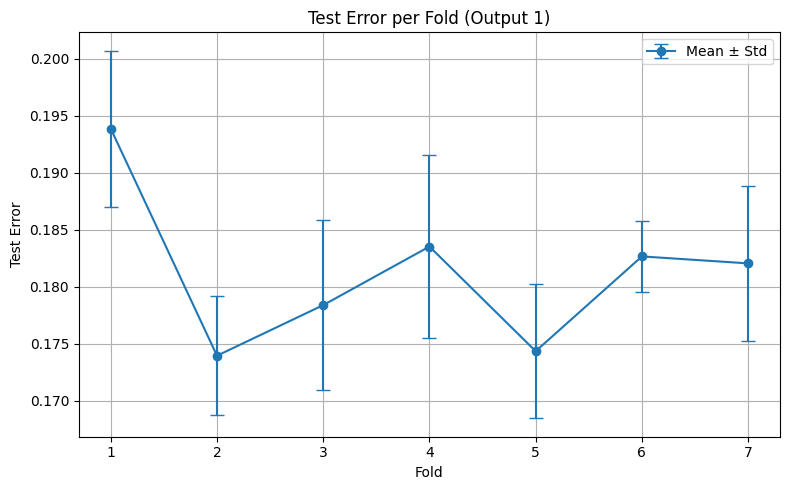


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.181050  0.186316  0.181397  0.175482  0.182086   0.181266  0.006184
std    0.009227  0.009885  0.010362  0.007268  0.007325   0.006781  0.001634
min    0.173706  0.176254  0.166239  0.163563  0.172446   0.173964  0.003126
25%    0.174663  0.178065  0.176009  0.171098  0.177502   0.176380  0.005557
50%    0.175582  0.184010  0.181188  0.177914  0.182035   0.182061  0.006766
75%    0.185217  0.192662  0.186716  0.179830  0.185652   0.183103  0.007130
max    0.198303  0.202494  0.196901  0.185038  0.193815   0.193872  0.008019

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.193872  0.006837
1   0.173964  0.005229
2   0.178401  0.007424
3   0.183536  0.008019
4   0.174359  0.005886
5   0.182670  0.003126
6   0.182061  0.006766

Per-fold Summary (across runs):
         Fold_1    F

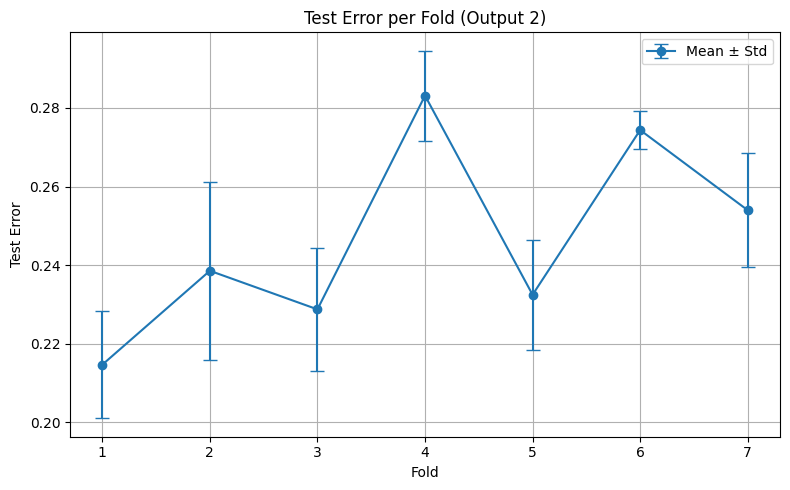


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.244209  0.239145  0.247858  0.247176  0.254470   0.246572  0.013834
std    0.027819  0.035593  0.021910  0.021525  0.035494   0.025034  0.005290
min    0.196853  0.203973  0.218821  0.217346  0.208979   0.214691  0.004918
25%    0.229588  0.212968  0.229816  0.235431  0.222925   0.230624  0.012536
50%    0.246075  0.232829  0.253004  0.245131  0.273071   0.238577  0.013980
75%    0.266099  0.255334  0.263231  0.260018  0.280744   0.264179  0.015085
max    0.275162  0.300611  0.277087  0.276855  0.291902   0.283129  0.022700

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.214691  0.013646
1   0.238577  0.022700
2   0.228764  0.015726
3   0.283129  0.011426
4   0.232484  0.013980
5   0.274376  0.004918
6   0.253981  0.014443

Per-fold Summary (across runs):
         Fold_1    F

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume sc_y_glob shape is (7, 5, 2) => (folds, runs, outputs)
n_outputs = sc_y_glob.shape[2]

for i in range(n_outputs):
    print(f"\n=== Summary for Output {i+1} ===")
    
    data_i = sc_y_glob[:, :, i]  # shape: (7, 5)
    
    fold_means = np.mean(data_i, axis=1)
    fold_stds = np.std(data_i, axis=1)

    overall_mean = np.mean(data_i)
    overall_std = np.std(data_i)

    # Print summary
    print("Per-Fold Means:", fold_means)
    print("Per-Fold Std Devs:", fold_stds)
    print(f"Overall Mean: {overall_mean:.4f}, Overall Std: {overall_std:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.errorbar(range(1, len(fold_means)+1), fold_means, yerr=fold_stds, fmt='o-', capsize=5, label='Mean ± Std')
    plt.title(f'Test Error per Fold (Output {i+1})')
    plt.xlabel('Fold')
    plt.ylabel('Test Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DataFrame Summary
    df_results = pd.DataFrame(data_i, columns=[f"Run_{j+1}" for j in range(data_i.shape[1])])
    df_results["Fold_Mean"] = df_results.mean(axis=1)
    df_results["Fold_Std"] = df_results.std(axis=1)

    print("\nSummary Statistics (per training run):")
    print(df_results.describe())

    print("\nPer-fold Means and Std Devs:")
    print(df_results[["Fold_Mean", "Fold_Std"]])

    df_fold_view = df_results.drop(columns=["Fold_Mean", "Fold_Std"]).T
    df_fold_view.columns = [f"Fold_{k+1}" for k in range(df_fold_view.shape[1])]

    print("\nPer-fold Summary (across runs):")
    print(df_fold_view.describe())

C:\Users\vkeerth\AppData\Local\Temp\ipykernel_3416\3604107887.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='best')


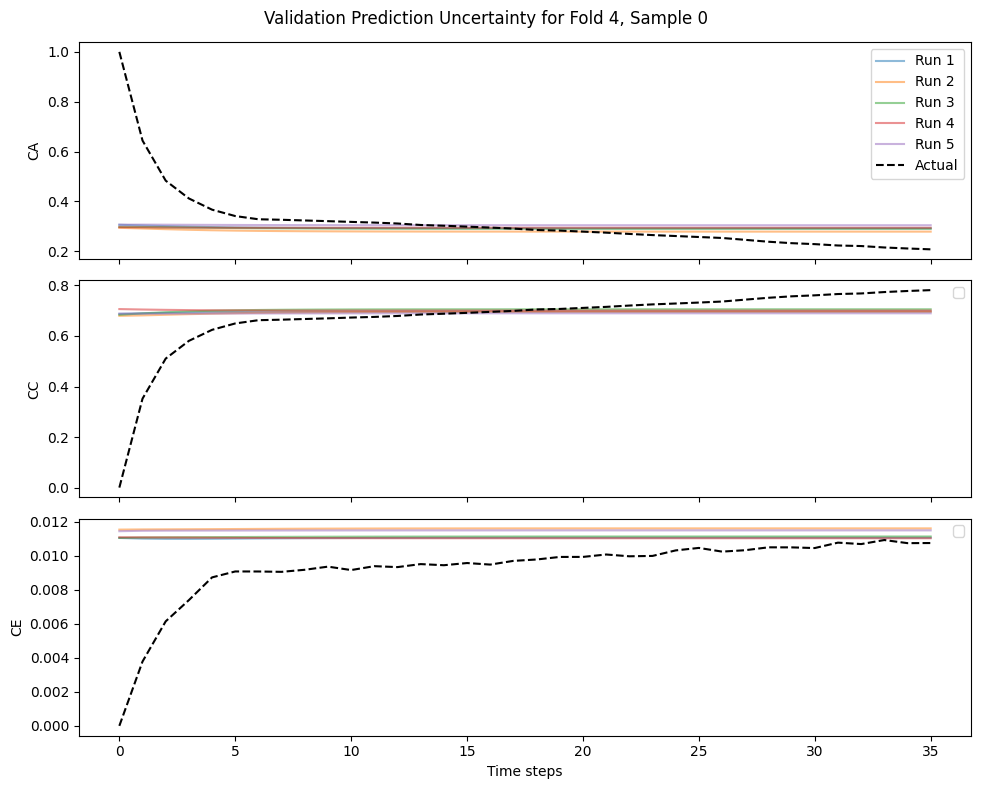

In [32]:
import matplotlib.pyplot as plt

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

time = np.arange(36)  # time steps

for i, label in enumerate(['CA', 'CC', 'CE']):
    for run in range(5):
        axs[i].plot(time, all_val_preds[fold_idx][run, sample_idx, :, i], alpha=0.5, label=f'Run {run+1}' if i==0 else None)

    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', label='Actual' if i==0 else None)
    axs[i].set_ylabel(label)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Time steps")
plt.suptitle(f"Validation Prediction Uncertainty for Fold {fold_idx+1}, Sample {sample_idx}")
plt.tight_layout()
plt.show()


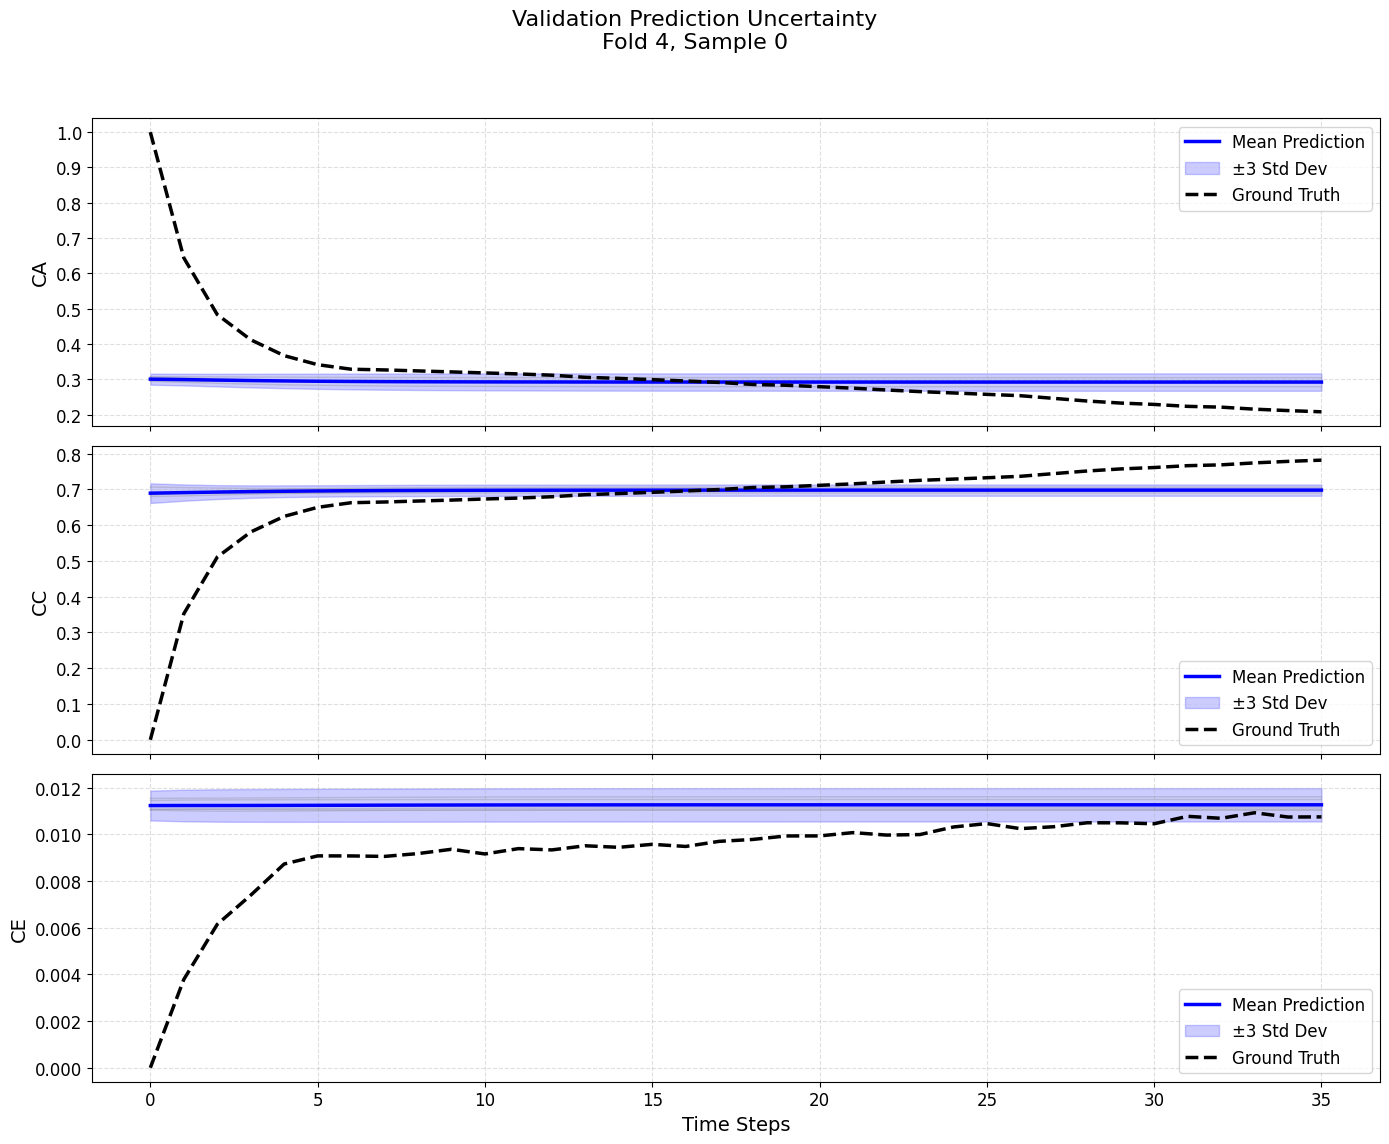

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set
time = np.arange(36)  # time steps
labels = ['CA', 'CC', 'CE']

n_runs = len(all_val_preds[fold_idx])

# Bigger figure and fonts
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, label in enumerate(labels):
    runs = np.array([all_val_preds[fold_idx][run, sample_idx, :, i] for run in range(n_runs)])
    mean_pred = runs.mean(axis=0)
    std_pred = runs.std(axis=0)

    # Light individual runs
    for run in range(n_runs):
        axs[i].plot(time, runs[run], color='gray', alpha=0.3, linewidth=1)

    # Mean and uncertainty
    axs[i].plot(time, mean_pred, color='blue', linewidth=2.5, label='Mean Prediction')
    axs[i].fill_between(time, mean_pred - 3*std_pred, mean_pred + 3*std_pred, 
                        color='blue', alpha=0.2, label='±3 Std Dev')

    # Ground truth
    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', linewidth=2.5, label='Ground Truth')

    axs[i].set_ylabel(label, fontsize=14)
    axs[i].legend(loc='best', fontsize=12)
    axs[i].tick_params(labelsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.4)

axs[-1].set_xlabel("Time Steps", fontsize=14)
plt.suptitle(f"Validation Prediction Uncertainty\nFold {fold_idx + 1}, Sample {sample_idx}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
